In [18]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Dosya yolu
file_path = '/content/finalemlak2.xlsx'

# Veri setini oku
df = pd.read_excel(file_path)


In [4]:
# Uç değer temizliği - price sütunu %5 en düşük ve %5 en yüksek sınırları çıkar
q_low = df['price'].quantile(0.05)
q_hi = df['price'].quantile(0.95)
df = df[(df['price'] > q_low) & (df['price'] < q_hi)].copy()

# Yeni özellik
df['price_sqm'] = df['price'] / df['grossSqm']

# Kategorik sütunlar
categorical_columns = [
    'district', 'county', 'residence', 'heating', 'fuel',
    'build', 'buildState', 'furnished', 'subCategory'
]

# Sayısal sütunlar (price ve kategorikler dışındakiler)
numeric_columns = [col for col in df.columns if col not in categorical_columns + ['price']]

# OneHotEncoding kategorik sütunlar için
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_columns])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_columns))
encoded_cat_df.reset_index(drop=True, inplace=True)

# Sayısal sütunları dataframe olarak al
numeric_df = df[numeric_columns].reset_index(drop=True)

# Sayısal ve kategorik sütunları birleştir
X = pd.concat([numeric_df, encoded_cat_df], axis=1)
y = df['price']

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizasyon
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV ile en iyi k değerini bul
param_grid = {'n_neighbors': list(range(1, 31))}
grid = GridSearchCV(KNeighborsRegressor(weights='distance'), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
print(f"GridSearchCV ile en iyi K: {best_k}")

# En iyi K ile modeli eğit
knn_best = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
knn_best.fit(X_train_scaled, y_train)

# Tahmin yap
y_pred = knn_best.predict(X_test_scaled)

# Performans metriklerini hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Skoru: {r2:.4f}")

# MAPE fonksiyonu
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: %{mape:.2f}")


GridSearchCV ile en iyi K: 10
MAE: 917936.39
RMSE: 1464287.91
R² Skoru: 0.7075
MAPE: %20.40


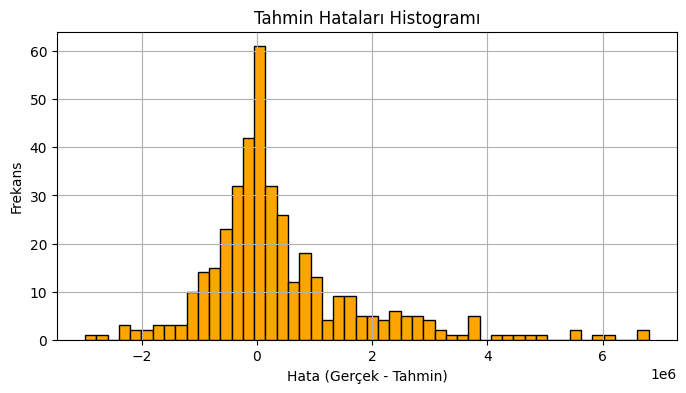

In [5]:
#HATA DAĞILIMI HİSTOGRAMI
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, color='orange', edgecolor='black')
plt.title("Tahmin Hataları Histogramı")
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

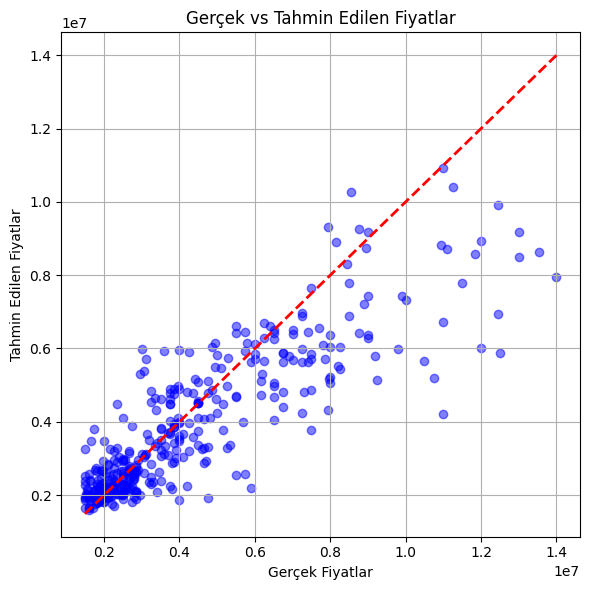

In [6]:
import matplotlib.pyplot as plt

# Scatter Plot (Gerçek vs Tahmin)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Doğruluk çizgisi
plt.xlabel("Gerçek Fiyatlar")
plt.ylabel("Tahmin Edilen Fiyatlar")
plt.title("Gerçek vs Tahmin Edilen Fiyatlar")
plt.grid(True)
plt.tight_layout()
plt.show()
#noktalar çizginin üstünde ise gerçekçi tahmin yapılır

In [8]:
import plotly.express as px
#treemap (ağaç haritası) grafiği, verilerdeki hiyerarşik yapıyı alan büyüklükleriyle ve renklerle görselleştirir.
fig = px.treemap(df,
                 path=['district', 'residence'],   #Hiyerarşi: önce ilçe, sonra konut tipi
                 values='price',                   #Her kutunun büyüklüğü: fiyat toplamına göre
                 color='price',                    #Renk: fiyatlara göre
                 color_continuous_scale='Viridis') # Renk geçiş skalası
fig.show()

In [9]:
def predict_price(model, scaler, example_dict, df_columns):
    import pandas as pd
    import numpy as np

    example_df = pd.DataFrame([example_dict])
    example_df_encoded = pd.get_dummies(example_df)
    example_df_encoded = example_df_encoded.reindex(columns=df_columns, fill_value=0)
    example_scaled = scaler.transform(example_df_encoded)

    log_price = model.predict(example_scaled)[0]
    predicted_price = np.expm1(log_price)  # log1p'in tersini al

    print(f"Tahmini Fiyat: {predicted_price:,.0f} TL")

In [10]:
# İlk 10 örnek için tahmin sonuçları
sample_preds = pd.DataFrame({
    'Gerçek Fiyat': y_test.values[:10],
    'Tahmin Edilen Fiyat': y_pred[:10]
})

# Virgülden sonra 2 basamakla yuvarla
sample_preds = sample_preds.round(2)

# Tahmin sonuçlarını yazdır
print("\n--- KNN ile Örnek Tahmin Sonuçları ---")
print(sample_preds)


--- KNN ile Örnek Tahmin Sonuçları ---
   Gerçek Fiyat  Tahmin Edilen Fiyat
0       1620000           2412618.99
1       2350000           2043510.23
2       2150000           1951315.95
3       1635000           1828674.50
4       3500000           3800116.92
5       3750000           4493540.52
6       7300000           4811275.56
7       3085000           3085000.00
8       1950000           1891995.36
9       2350000           2612045.64


In [11]:
# Sakarya'da örnek daire verisi
sample_data = {
    'district': 'Serdivan',
    'county': 'Sakarya',
    'residence': 'Apartman',
    'heating': 'Doğalgaz (Kombi)',
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'İkinci El',
    'furnished': 'Eşyasız',
    'subCategory': 'Satılık Daire',
    'netSqm': 85,
    'grossSqm': 100,
    'age': 5,
    'room': 3,
    'bathRoom': 1,
    'livingRoom': 1,
    'bina_kat_sayisi': 4,
    'daire_kati': 3
}

In [12]:

for col in numeric_columns:
    if col not in sample_data:
        sample_data[col] = 0

#  Encode ve scale işlemleri
sample_df = pd.DataFrame([sample_data])
sample_cat = encoder.transform(sample_df[categorical_columns])
sample_cat_df = pd.DataFrame(sample_cat, columns=encoder.get_feature_names_out(categorical_columns))
sample_num_df = sample_df[numeric_columns].reset_index(drop=True)
sample_X = pd.concat([sample_num_df, sample_cat_df], axis=1)
sample_X = sample_X.reindex(columns=X_train.columns, fill_value=0)
sample_X_scaled = scaler.transform(sample_X)


predicted_price = knn_best.predict(sample_X_scaled)[0]
print(f" Sakarya'daki Daire İçin Tahmin Edilen Fiyat: {predicted_price:.2f} TL")


 Sakarya'daki Daire İçin Tahmin Edilen Fiyat: 2611928.98 TL


In [13]:
# Sakarya / Serdivan'daki örnek daire
sample_data = {
    'district': 'Serdivan',              # İlçesi
    'county': 'Sakarya',                 # Şehir
    'residence': 'Apartman',             # Konut tipi
    'heating': 'Doğalgaz (Kombi)',       # Isıtma tipi
    'fuel': 'Doğalgaz',                  # Yakıt tipi
    'build': 'Betonarme',                # Yapı tipi
    'buildState': 'İkinci El',           # Yeni / 2. el
    'furnished': 'Eşyasız',              # Eşyalı mı
    'subCategory': 'Satılık Daire',      # İlan türü

    'netSqm': 90,                        # Net m²
    'grossSqm': 105,                     # Brüt m²
    'age': 6,                            # Bina yaşı
    'room': 3,                           # Oda sayısı
    'bathRoom': 1,                       # Banyo sayısı
    'livingRoom': 1,                     # Salon sayısı
    'bina_kat_sayisi': 4,                # Binanın toplam katı
    'daire_kati': 3                      # Dairenin bulunduğu kat
}


In [ ]:
for col in numeric_columns:
    if col not in sample_data:
        sample_data[col] = 0

# Encode + ölçekleme + tahmin
sample_df = pd.DataFrame([sample_data])
sample_cat = encoder.transform(sample_df[categorical_columns])
sample_cat_df = pd.DataFrame(sample_cat, columns=encoder.get_feature_names_out(categorical_columns))
sample_num_df = sample_df[numeric_columns].reset_index(drop=True)
sample_X = pd.concat([sample_num_df, sample_cat_df], axis=1)
sample_X = sample_X.reindex(columns=X_train.columns, fill_value=0)
sample_X_scaled = scaler.transform(sample_X)

# Tahmini fiyat
predicted_price = knn_best.predict(sample_X_scaled)[0]
print(f" Sakarya / Serdivan Tahmini Fiyat: {predicted_price:.2f} TL")


 Sakarya / Serdivan Tahmini Fiyat: 2611933.16 TL


In [14]:
# Tüm kategorik sütunlar eklenmiş şekilde
sample_data = {
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'İkinci El',
    'furnished': 'DOĞRU',
    'subCategory': 'Müstakil Ev',
    'county': 'Sakarya',
    'district': 'Serdivan',
    'heating': 'Merkezi Sistem',
    'residence': 'Bahçeli',

    'netSqm': 100,
    'grossSqm': 150,
    'ha_kat_sayı': 2,
    'daire_katı': 0,
    'kuzey': 1,
    'guney': 1,
    'dogu': 1,
    'bati': 1,
    'goldeniz': 0,
    'bahceli': 1,
    'havuzlu': 0
}


In [15]:
#  Encoder fit sırasında kullanılan kategorik değişken sırası
categorical_columns = [
    'district', 'county', 'residence', 'heating',
    'fuel', 'build', 'buildState', 'furnished', 'subCategory'
]

#  Sayısal ve binary değişkenler
numeric_columns = [
    'netSqm', 'grossSqm', 'ha_kat_sayı', 'daire_katı',
    'kuzey', 'guney', 'dogu', 'bati', 'goldeniz', 'bahceli', 'havuzlu'
]

#  Örnek ev:  Sakarya Serdivan, bahçeli, müstakil
sample_data = {
    'district': 'Serdivan',
    'county': 'Sakarya',
    'residence': 'Bahçeli',
    'heating': 'Merkezi Sistem',
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'İkinci El',
    'furnished': 'DOĞRU',
    'subCategory': 'Müstakil Ev',

    'netSqm': 100,
    'grossSqm': 150,
    'ha_kat_sayı': 2,
    'daire_katı': 0,
    'kuzey': 1,
    'guney': 1,
    'dogu': 1,
    'bati': 1,
    'goldeniz': 0,
    'bahceli': 1,
    'havuzlu': 0
}

#  DataFrame'e çevir
sample_df = pd.DataFrame([sample_data])
#  Kategorik encode (tam sıra)
sample_cat = encoder.transform(sample_df[categorical_columns])
sample_cat_df = pd.DataFrame(sample_cat, columns=encoder.get_feature_names_out(categorical_columns))

#  Sayısal kısmı al
sample_num_df = sample_df[numeric_columns].reset_index(drop=True)

#  Sayısal + encode birleşimi
sample_X = pd.concat([sample_num_df, sample_cat_df], axis=1)

#  Modelin beklediği sütun sırasına göre hizala
sample_X = sample_X.reindex(columns=X_train.columns, fill_value=0)

#  Ölçekle
sample_X_scaled = scaler.transform(sample_X)

# Tahmin et
predicted_price = knn_best.predict(sample_X_scaled)[0]
print(f" Sakarya / Serdivan Bahçeli Müstakil Ev Tahmini Fiyat: {predicted_price:.0f} TL")


 Sakarya / Serdivan Bahçeli Müstakil Ev Tahmini Fiyat: 6117477 TL


In [17]:
#  Encoder fit sırasında kullanılan kategorik değişken sırası
categorical_columns = [
    'district', 'county', 'residence', 'heating',
    'fuel', 'build', 'buildState', 'furnished', 'subCategory'
]

#  Sayısal ve binary değişkenler
numeric_columns = [
    'netSqm', 'grossSqm', 'room', 'age','livingRoom','bathRoom', 'bina_kat_sayi', 'daire_kati',
    'kuzey', 'guney', 'dogu', 'bati', 'goldeniz', 'bahceli', 'havuzlu'
]

#  Örnek ev:  Sakarya Serdivan, bahçeli, müstakil
sample_data = {
    'district': 'Serdivan',
    'county': 'Sakarya',
    'residence': 'Bahçeli',
    'room': 3,
    'bathRoom': 1,
    'livingRoom': 1,
    'age': 5,
    'heating': 'Merkezi Sistem',
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'İkinci El',
    'furnished': 'DOĞRU',
    'subCategory': 'Müstakil Ev',

    'netSqm': 100,
    'grossSqm': 150,
    'bina_kat_sayi': 2,
    'daire_kati': 0,
    'kuzey': 1,
    'guney': 1,
    'dogu': 1,
    'bati': 1,
    'goldeniz': 0,
    'bahceli': 1,
    'havuzlu': 0
}

#  DataFrame'e çevir
sample_df = pd.DataFrame([sample_data])
#  Kategorik encode (tam sıra)
sample_cat = encoder.transform(sample_df[categorical_columns])
sample_cat_df = pd.DataFrame(sample_cat, columns=encoder.get_feature_names_out(categorical_columns))

#  Sayısal kısmı al
sample_num_df = sample_df[numeric_columns].reset_index(drop=True)

#  Sayısal + encode birleşimi
sample_X = pd.concat([sample_num_df, sample_cat_df], axis=1)

#  Modelin beklediği sütun sırasına göre hizala
sample_X = sample_X.reindex(columns=X_train.columns, fill_value=0)

#  Ölçekle
sample_X_scaled = scaler.transform(sample_X)

# Tahmin et
predicted_price = knn_best.predict(sample_X_scaled)[0]
print(f" Sakarya / Serdivan Bahçeli Müstakil Ev Tahmini Fiyat: {predicted_price:.0f} TL")


 Sakarya / Serdivan Bahçeli Müstakil Ev Tahmini Fiyat: 6821684 TL
